# 内容一：在MNIST数据集上构建网络进行分类

## 1. 实验前导

In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import torch.utils.data as tud
import numpy as np

## 2. 准备数据

### 学会使用Dataloader来加载数据
Dataloader能够帮我们打乱数据集，拿到batch数据 \
为了使用Dataloader，需要定义以下三个function
- \__init__: 模型初始化
- \__len__: 返回整个数据集有多少item
- \__getitem__: 根据给定的index返回一个item

调用Dataloader之前还要先定义dataset

In [2]:
# Pytorch帮助我们预先加载了一些常用的数据集
# 如果使用这些数据集，会相对容易的进行数据加载
# 例如：常用的Mnist数据集
mnist_train_data = datasets.MNIST("./mnist_data",train=True,download=True,
                                 transform = transforms.Compose([
                                     transforms.ToTensor(),
                                     transforms.Normalize(mean=(0.13066062,),std=(0.30810776,))
                                 ]))
batch_size = 64
train_dataloader = tud.DataLoader(mnist_train_data,batch_size = batch_size,shuffle=True) # 将dataset转换为iterator
mnist_test_data = datasets.MNIST("./mnist_data",train=False,download=True,
                                 transform = transforms.Compose([
                                     transforms.ToTensor(),
                                     transforms.Normalize(mean=(0.13066062,),std=(0.30810776,))
                                 ]))
test_dataloader = tud.DataLoader(mnist_test_data,batch_size = batch_size)

In [3]:
mnist_data = datasets.MNIST("./mnist_data",train=True,download=True)

In [4]:
mnist_data[9][0]

In [5]:
mnist_data = datasets.MNIST("./mnist_data", train=True, download=True,
                           transform = transforms.Compose([
                               transforms.ToTensor()
                           ]))

In [6]:
mnist_data[9][0]

tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,

In [7]:
data = [d[0].data.numpy() for d in mnist_data]
np.std(data)

0.30810776

## 3. 配置网络

### (1) 定义网络
- 继承 nn.Module
- 初始化函数
- forward 函数
- 其余可以根据模型需要定义相关的函数

In [8]:
# 定义一个简单的基于ConvNet的简单神经网络
class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__() # the input is 1*28*28
        self.conv1 = nn.Conv2d(1,20,5,1) # (28-5)/1+1=24, 20*24*24
        self.conv2 = nn.Conv2d(20,50,5,1) # 12-5+1=8
        self.fc1 = nn.Linear(4*4*50,500)
        self.fc2 = nn.Linear(500,10)
    def forward(self,x):
        x = F.relu(self.conv1(x)) # 20 * 24 * 24
        x = F.max_pool2d(x,2,2) # 20 * 12 * 12
        x = F.relu(self.conv2(x)) # 50 * 8 * 8
        x = F.max_pool2d(x,2,2) # 50 * 4 * 4
        x = x.view(-1,4*4*50)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x #F.log_softmax(x,dim=1)
model = Net()

### (2) 定义损失函数

In [9]:
loss_fn = nn.CrossEntropyLoss(reduction='mean')

### (3) 定义优化算法

In [10]:
lr = 0.01
momentum = 0.5
optimizer = optim.SGD(model.parameters(),lr=lr,momentum=momentum)

## 4. 训练网络

- 模型一般需要训练若干个epoch
- 每个epoch我们把所有数据分成若干个batch
- 把每个batch的输入和输出都包装成cuda Tensor
- forward pass
- 计算loss
- 清空gradient
- backward pass
- 更新模型参数
- 每隔一定的iteration输出loss，以及在验证集上做模型的评估

In [11]:
def train(model,train_dataloader,loss_fn,optimizer,epoch):
    model.train()
    for idx, (data, label) in enumerate(train_dataloader):
        output = model(data)
        loss = loss_fn(output,label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if idx % 100 == 0:
            print("Train Epoch: {}, iteration: {}, loss: {}".format(
                epoch,idx,loss.item()))  
    return model

## 5. 模型评估

In [12]:
def test(model,test_dataloader,loss_fn):
    model.eval()
    total_loss = 0.
    correct = 0.
    with torch.no_grad():
        for idx, (data,target) in enumerate(test_dataloader):
            output = model(data) # batch_size * 10        
            loss = loss_fn(output,target)*output.size(0)
            pred = output.argmax(dim=1)
            total_loss += loss
            correct += pred.eq(target).sum()
    total_loss /= len(test_dataloader.dataset)
    acc = correct/len(test_dataloader.dataset)
    print("Test Loss:{}, Accuracy:{}".format(total_loss,acc))
    return acc

## 6. 模型存储

In [13]:
#torch.save(model.state_dict(),"mnist_cnn.pth")
num_epochs = 2
best_valid_acc = 0.
for epoch in range(num_epochs):
    train(model,train_dataloader,loss_fn,optimizer,epoch)
    acc = test(model,test_dataloader,loss_fn)
    if acc > best_valid_acc:
        best_valid_acc = acc
        torch.save(model.state_dict(),"best_mnist_cnn.pth")

Train Epoch: 0, iteration: 0, loss: 2.3114867210388184
Train Epoch: 0, iteration: 100, loss: 0.8056374788284302
Train Epoch: 0, iteration: 200, loss: 0.3295554220676422
Train Epoch: 0, iteration: 300, loss: 0.14907078444957733
Train Epoch: 0, iteration: 400, loss: 0.3567638099193573
Train Epoch: 0, iteration: 500, loss: 0.31864452362060547
Train Epoch: 0, iteration: 600, loss: 0.13163012266159058
Train Epoch: 0, iteration: 700, loss: 0.06611235439777374
Train Epoch: 0, iteration: 800, loss: 0.04001199081540108
Train Epoch: 0, iteration: 900, loss: 0.18037915229797363
Test Loss:0.09847679734230042, Accuracy:0.9710999727249146
Train Epoch: 1, iteration: 0, loss: 0.11229132860898972
Train Epoch: 1, iteration: 100, loss: 0.06748390942811966
Train Epoch: 1, iteration: 200, loss: 0.038600947707891464
Train Epoch: 1, iteration: 300, loss: 0.04738940671086311
Train Epoch: 1, iteration: 400, loss: 0.0798511803150177
Train Epoch: 1, iteration: 500, loss: 0.019416717812418938
Train Epoch: 1, iter

### Load模型

In [14]:
test_model = Net()
test_model.load_state_dict(torch.load("best_mnist_cnn.pth"))
test(model,test_dataloader,loss_fn)

Test Loss:0.05717659741640091, Accuracy:0.9818000197410583


tensor(0.9818)

### For FashionMNIST

In [16]:
# FashionMNIST数据集
mnist_train_data = datasets.FashionMNIST("./fashion_mnist_data",train=True,download=True,
                                 transform = transforms.Compose([
                                     transforms.ToTensor(),
                                     transforms.Normalize(mean=(0.13066062,),std=(0.30810776,))
                                 ]))
batch_size = 64
train_dataloader = tud.DataLoader(mnist_train_data,batch_size = batch_size,shuffle=True) # 将dataset转换为iterator
mnist_test_data = datasets.FashionMNIST("./fashion_mnist_data",train=False,download=True,
                                 transform = transforms.Compose([
                                     transforms.ToTensor(),
                                     transforms.Normalize(mean=(0.13066062,),std=(0.30810776,))
                                 ]))
test_dataloader = tud.DataLoader(mnist_test_data,batch_size = batch_size)

In [18]:
model = Net()
loss_fn = nn.CrossEntropyLoss(reduction='mean')
lr = 0.01
momentum = 0.5
optimizer = optim.SGD(model.parameters(),lr=lr,momentum=momentum)
num_epochs = 2
best_valid_acc = 0.
for epoch in range(num_epochs):
    train(model,train_dataloader,loss_fn,optimizer,epoch)
    acc = test(model,test_dataloader,loss_fn)
    if acc > best_valid_acc:
        best_valid_acc = acc
        torch.save(model.state_dict(),"best_fashion_mnist_cnn.pth")

Train Epoch: 0, iteration: 0, loss: 2.328911781311035
Train Epoch: 0, iteration: 100, loss: 0.9987826347351074
Train Epoch: 0, iteration: 200, loss: 0.7665319442749023
Train Epoch: 0, iteration: 300, loss: 0.8882497549057007
Train Epoch: 0, iteration: 400, loss: 0.7011545300483704
Train Epoch: 0, iteration: 500, loss: 0.5955065488815308
Train Epoch: 0, iteration: 600, loss: 0.932137131690979
Train Epoch: 0, iteration: 700, loss: 0.5328547358512878
Train Epoch: 0, iteration: 800, loss: 0.5334343910217285
Train Epoch: 0, iteration: 900, loss: 0.6081203818321228
Test Loss:0.5485048294067383, Accuracy:0.7797999978065491
Train Epoch: 1, iteration: 0, loss: 0.5807403922080994
Train Epoch: 1, iteration: 100, loss: 0.4633340835571289
Train Epoch: 1, iteration: 200, loss: 0.5963548421859741
Train Epoch: 1, iteration: 300, loss: 0.4349920153617859
Train Epoch: 1, iteration: 400, loss: 0.4948941171169281
Train Epoch: 1, iteration: 500, loss: 0.6521319150924683
Train Epoch: 1, iteration: 600, loss

# 内容二：CNN模型的迁移学习

- 很多时候当我们训练一个新的图像分类任务，我们不会完全从一个随机的模型开始训练，而是利用预训练的模型来加速训练的过程。我们经常使用在ImageNet上的预训练模型
- 有两种方法做迁移学习
    - finetuning：从一个预训练模型开始，改变一些模型的架构，然后继续训练整个模型的参数；
    - feature extraction：不改变预训练模型的参数，只更新我们改变过的部分模型参数。（当成特征提取器来使用）

## 1. 实验前导

In [19]:
import os
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import models, datasets, transforms
import torch.utils.data as tud
import numpy as np

## 2. 准备数据

数据：使用hymenoptera_data数据集 \
数据集包括两类图片，bees和ants。这些数据都被处理成了可以使用ImageFolder来读取的格式。我们只需要把data_dir设置成数据的根目录，然后把model_name设置成我们想要使用的预训练模型

In [20]:
# format
data_dir = "./hymenoptera_data"
model_name = "resnet18"
num_class = 2
#feature_extract = True
input_size = 224

读入数据: 把数据预处理成相应的格式

In [22]:
# progress
all_imgs = datasets.ImageFolder(os.path.join(data_dir,"train"),
                                transform=transforms.Compose([
                                    transforms.RandomResizedCrop(input_size),
                                    transforms.RandomHorizontalFlip(),
                                    transforms.ToTensor(),                                    
                                ]))
loader = tud.DataLoader(all_imgs,batch_size=batch_size,shuffle=True)

In [23]:
all_imgs[9][0]

tensor([[[0.7412, 0.7294, 0.7294,  ..., 0.6196, 0.6157, 0.6118],
         [0.7490, 0.7412, 0.7333,  ..., 0.5882, 0.5922, 0.5961],
         [0.7529, 0.7451, 0.7412,  ..., 0.5765, 0.5765, 0.5843],
         ...,
         [0.4471, 0.4627, 0.4549,  ..., 0.5333, 0.5569, 0.5529],
         [0.4510, 0.4627, 0.4627,  ..., 0.5529, 0.5804, 0.5804],
         [0.4824, 0.4824, 0.4824,  ..., 0.5608, 0.5843, 0.5608]],

        [[0.6314, 0.6275, 0.6275,  ..., 0.4902, 0.4824, 0.4863],
         [0.6392, 0.6353, 0.6314,  ..., 0.4667, 0.4667, 0.4667],
         [0.6392, 0.6392, 0.6353,  ..., 0.4588, 0.4588, 0.4627],
         ...,
         [0.2784, 0.3255, 0.3373,  ..., 0.4196, 0.4431, 0.4078],
         [0.3255, 0.3529, 0.3725,  ..., 0.4431, 0.4549, 0.4157],
         [0.4000, 0.3961, 0.4039,  ..., 0.4392, 0.4196, 0.3647]],

        [[0.5059, 0.4980, 0.5020,  ..., 0.3725, 0.3686, 0.3725],
         [0.5137, 0.5098, 0.5059,  ..., 0.3529, 0.3490, 0.3569],
         [0.5216, 0.5176, 0.5137,  ..., 0.3490, 0.3490, 0.

In [24]:
# format
batch_size = 32
train_imgs = datasets.ImageFolder(os.path.join(data_dir,"train"),
                                transform=transforms.Compose([
                                    transforms.RandomResizedCrop(input_size),
                                    transforms.RandomHorizontalFlip(),
                                    transforms.ToTensor(),
                                    transforms.Normalize([0.485, 0.456, 0.406],[0.229,0.224,0.225])
                                ]))
train_dataloader = tud.DataLoader(train_imgs,batch_size=batch_size,shuffle=True)
test_imgs = datasets.ImageFolder(os.path.join(data_dir,"val"),
                                transform=transforms.Compose([
                                    transforms.Resize(input_size),  
                                    transforms.CenterCrop(input_size),
                                    transforms.ToTensor(),
                                    transforms.Normalize([0.485, 0.456, 0.406],[0.229,0.224,0.225])
                                ]))
test_dataloader = tud.DataLoader(test_imgs,batch_size=batch_size)

## 3. 配置网络

### (1) 定义网络

In [25]:
# format
def initialize_model(model_name,num_class,use_pretrained=True,feature_extract=True):
    if model_name == "resnet18":
        model_ft = models.resnet18(pretrained=use_pretrained)
        if feature_extract: # do not update the parameters
            for param in model_ft.parameters():
                param.requires_grad = False
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs,num_class)        
    else:
        print("model not implemented")
        return None
    return model_ft
model_ft = initialize_model("resnet18",2,use_pretrained=True,feature_extract=True)

D:\Software\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
D:\Software\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\16040/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth
100%|█████████████████████████████████████████████████████████████████████████████| 44.7M/44.7M [00:14<00:00, 3.34MB/s]


In [26]:
model_ft

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [27]:
print(model_ft.layer1[0].conv1.weight.requires_grad)
print(model_ft.fc.weight.requires_grad)

False
True


### (2) 定义损失函数

In [28]:
loss_fn = nn.CrossEntropyLoss()

### (3) 定义优化算法

In [29]:
lr = 0.01
momentum = 0.5
optimizer = optim.SGD(model_ft.parameters(),lr=lr,momentum=momentum)

## 4. 训练网络

In [30]:
def train_model(model,train_dataloader,loss_fn,optimizer,epoch):
    model.train()
    total_loss = 0.
    total_corrects = 0.
    for idx, (inputs, labels) in enumerate(train_dataloader):
        outputs = model(inputs)
        loss = loss_fn(outputs,labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        preds = outputs.argmax(dim=1)
        total_loss += loss.item() * inputs.size(0)
        total_corrects += torch.sum(preds.eq(labels))
    epoch_loss = total_loss / len(train_dataloader.dataset)
    epoch_accuracy = total_corrects / len(train_dataloader.dataset)
    print("Epoch:{}, Training Loss:{}, Traning Acc:{}".format(epoch,epoch_loss,epoch_accuracy))  
    #return model        

## 5. 模型评估

In [31]:
def test_model(model,test_dataloader,loss_fn):
    model.eval()
    total_loss = 0.
    total_corrects = 0.
    with torch.no_grad():
        for idx, (inputs, labels) in enumerate(test_dataloader):
            outputs = model(inputs)
            loss = loss_fn(outputs,labels)
            preds = outputs.argmax(dim=1)
            total_loss += loss.item() * inputs.size(0)
            total_corrects += torch.sum(preds.eq(labels))
    epoch_loss = total_loss / len(test_dataloader.dataset)
    epoch_accuracy = total_corrects / len(test_dataloader.dataset)
    print("Test Loss:{}, Test Acc:{}".format(epoch_loss,epoch_accuracy))  
    return epoch_accuracy 

In [32]:
num_epochs = 5
test_accuracy_hist = []
for epoch in range(num_epochs):
    train_model(model_ft,train_dataloader,loss_fn,optimizer,epoch)
    acc = test_model(model_ft,test_dataloader,loss_fn)
    test_accuracy_hist.append(acc)

Epoch:0, Training Loss:0.6341719598066612, Traning Acc:0.6516393423080444
Test Loss:0.3374541690147001, Test Acc:0.8692810535430908
Epoch:1, Training Loss:0.40357414327683994, Traning Acc:0.8237704634666443
Test Loss:0.23625953563677718, Test Acc:0.9477124214172363
Epoch:2, Training Loss:0.33447326646476494, Traning Acc:0.8524590134620667
Test Loss:0.21194470571536644, Test Acc:0.9411764740943909
Epoch:3, Training Loss:0.24367607372706054, Traning Acc:0.9303278923034668
Test Loss:0.23756680457420598, Test Acc:0.8954248428344727
Epoch:4, Training Loss:0.24827324342532237, Traning Acc:0.9057376980781555
Test Loss:0.21434232105616652, Test Acc:0.9281045794487


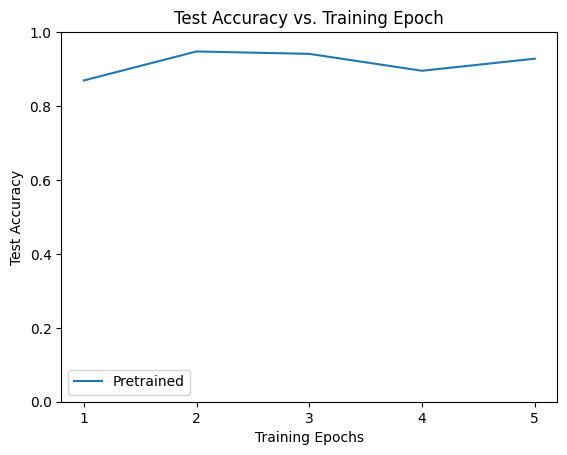

In [33]:
import matplotlib.pyplot as plt
#torch.save(model.state_dict(),"new_cnn.pth")
plt.title("Test Accuracy vs. Training Epoch")
plt.xlabel("Training Epochs")
plt.ylabel("Test Accuracy")
plt.plot(range(1,num_epochs+1),test_accuracy_hist,label="Pretrained")
plt.ylim((0,1.))
plt.xticks(np.arange(1,num_epochs+1,1.0))
plt.legend()
plt.show()

# 拓展代码

## 可视化卷积核

## GradCam